In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

In [9]:
alpha = 1.4
beta = 0.3

def func(x_n, y_n):
    x_n_plus_1 = 1 - alpha*(x_n**2) + y_n
    y_n_plus_1 = beta*x_n
    
    return x_n_plus_1, y_n_plus_1


def henon_map_trajectory(x_i, y_i, steps):
    x_t = []
    y_t = []
    
    x_t.append(x_i)
    y_t.append(y_i)
    
    for n in range(steps-1):
        x, y = func(x_t[n], y_t[n])
        x_t.append(x)
        y_t.append(y)
        
    return x_t, y_t

In [10]:
x_i = round(np.random.random()*1.5 - 0.75, 1) 
y_i = round(np.random.random()*0.6 - 0.3, 1) 

steps = 10000
x_t, y_t = henon_map_trajectory(x_i, y_i, steps)

print(x_i, y_i)

-0.0 0.2


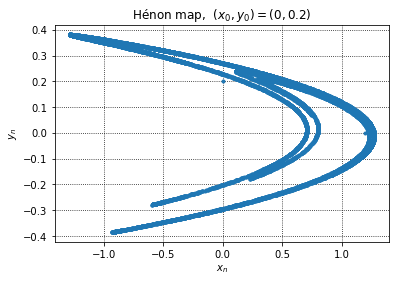

In [20]:
plt.plot(x_t, y_t, '.')
plt.ylabel(r'$y_n$ ')
plt.xlabel(r'$x_n$ ')
plt.title('Hénon map,  ' + '$(x_0, y_0) = (0, 0.2)$')
plt.grid(True, color= 'k', linestyle = ':')
plt.rcParams['xtick.labelsize']=10
plt.savefig("Hénon map trajectory .png", dpi=(250), edgecolor='#f0f0f0', bbox_inches="tight") 

In [12]:
def euclidean_distance(x_i, x_j):
    d_sq = (x_i[0] - x_j[0])**2 + (x_i[1] - x_j[1])**2           
    d = np.sqrt(d_sq)
    return d

In [13]:
M = np.zeros((steps, steps), dtype=float)

start = time.time()

for i in range(steps):
    for j in range(i+1, steps):
        M[i][j] = euclidean_distance([x_t[i], y_t[i]], [x_t[j], y_t[j]])
        
end = time.time()
print(end - start, " seconds")

96.15109729766846  seconds


In [14]:
euc_dist_matrix = M

We are interested in calculating the correlation integral approximated by the following sum - 
$$C(\varepsilon) = \lim_{N \rightarrow \infty} \frac{2}{N(N-1)} \sum_{i = 1}^N \sum_{j = i + 1}^N \Theta(\varepsilon - || \vec{x}(i) - \vec{x}(j)||)$$

Here we have chosen $N = 10^4$.

We have already calculated the Euclidean distances between the points $\vec{x}_i$ and $\vec{x}_j$ and stored them in the form of a matrix $M_{ij} = || \vec{x}(i) - \vec{x}(j)||$. From now on, we'll call the euclidean distances as the entries $M_{ij}$ of matrix $\textbf{M}$. 

The quantity that we are performing the double sum over is $\Theta(\epsilon - M_{ij})$.
$$\Theta(\epsilon - M_{ij}) = \begin{cases} 0, & M_{ij} > \epsilon \\ 1, & 0 < M_{ij} < \epsilon \end{cases}$$

To do this in Python, we simply compare the numpy array of matrix $\textbf{M}$ with the value $\epsilon$ i.e. $\textbf{M} < \epsilon$ returns a matrix with True and False, but it also sets $0$ distance to True as well. To counter this, we apply a logical and operator such that 
$$ 0 < \textbf{M} \quad \text{AND} \quad \textbf{M} < \epsilon$$
Once we get this matrix, we can convert all True entries to $1$ and all False values to $0$, and then take a sum over the entire matrix. This essentially gives us the required sum -  
$$S (\epsilon) = \sum_{i = 1}^N \sum_{j = i + 1}^N \Theta(\varepsilon - || \vec{x}(i) - \vec{x}(j)||)$$

In [15]:
def sum_eps(eps, euc_dist_matrix):
    s = np.sum(np.logical_and((euc_dist_matrix < eps), (euc_dist_matrix > 0)).astype(int))
    return s

def correlation_sum(eps, euc_dist_matrix):
    N = len(euc_dist_matrix)
    #C = (1*sum_eps(eps, euc_dist_matrix))/(N*(N))
    C = (2*sum_eps(eps, euc_dist_matrix))/(N*(N - 1))
    return C

Once we have the sum, the correlation sum looks like 
$$C(\epsilon) = \frac{2}{N(N-1)} S(\epsilon)$$

In [16]:
correlation_sum(0.0001, euc_dist_matrix)

1.114111411141114e-05

In [17]:
eps_array = np.logspace(-9, 1.1, num=300, base=np.e)
correlation_sum_list = []

start_1 = time.time()

for eps in eps_array:
    correlation_sum_list.append(correlation_sum(eps, euc_dist_matrix))
    
correlation_sum_array = np.array(correlation_sum_list)

end_1 = time.time()
print(end_1 - start_1, " seconds")

119.6408360004425  seconds


Correlation Dimension =  1.2114945149977057 ± 0.0010129104938386264


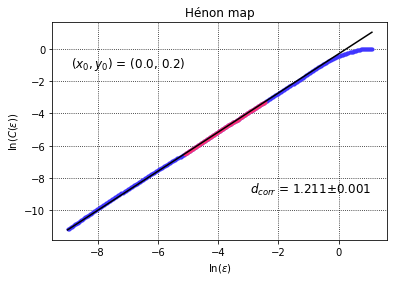

In [19]:
a = 115
b = -105

#plt.plot((eps_array), (correlation_sum_array), '.-')
plt.plot(np.log(eps_array), np.log(correlation_sum_array), '.-', color = '#4036ff')
plt.plot(np.log(eps_array)[a:b], np.log(correlation_sum_array)[a:b], '.-', color = '#fc3078')


import scipy.stats as st
result = st.linregress(np.log(eps_array)[a:b], np.log(correlation_sum_array)[a:b])
m = result.slope
delta_m = result.stderr
c = result.intercept
delta_c = result.intercept_stderr
plt.plot(np.log(eps_array), m*np.log(eps_array) + c, color = 'black')
plt.ylabel(r'$\ln (C(\epsilon))$ ')
plt.xlabel(r'$\ln (\epsilon)$ ')
plt.title('Hénon map')
plt.grid(True, color= 'k', linestyle = ':')
plt.rcParams['xtick.labelsize']=10
print("Correlation Dimension = ", m, "±", delta_m)
plt.text(min(np.log(eps_array)) + 0.6*(max(np.log(eps_array))-min(np.log(eps_array))), 0.8*(max(np.log(correlation_sum_array))+min(np.log(correlation_sum_array))), r'$d_{corr}$ = ' + str(round(m,3)) + "±" + str(round(delta_m,3)), fontsize = 12)
plt.text(min(np.log(eps_array)) + 0.01*(max(np.log(eps_array))-min(np.log(eps_array))), 0.1*(max(np.log(correlation_sum_array))+min(np.log(correlation_sum_array))), r'$(x_0, y_0)$ = (0.0, 0.2) ', fontsize = 12)
plt.savefig("Hénon map ln(C) vs ln(eps).png" , dpi=(250), edgecolor='#f0f0f0', bbox_inches="tight") 
plt.show()